In [1]:
#install.packages('NMF', repos='http://cran.us.r-project.org')
library(NMF)
library(matrixStats)
library(GEOquery)
library(matrixStats)

source("https://bioconductor.org/biocLite.R")
biocLite('Biobase')
biocLite('GEOquery')

Loading required package: pkgmaker
Loading required package: registry

Attaching package: 'pkgmaker'

The following object is masked from 'package:base':

    isNamespaceLoaded

Loading required package: rngtools
Loading required package: cluster
NMF - BioConductor layer [OK] | Shared memory capabilities [NO: windows] | Cores 3/4
matrixStats v0.51.0 (2016-10-08) successfully loaded. See ?matrixStats for help.

Attaching package: 'matrixStats'

The following objects are masked from 'package:Biobase':

    anyMissing, rowMedians

Setting options('download.file.method.GEOquery'='auto')
Setting options('GEOquery.inmemory.gpl'=FALSE)
Bioconductor version 3.4 (BiocInstaller 1.24.0), ?biocLite for help
BioC_mirror: https://bioconductor.org
Using Bioconductor 3.4 (BiocInstaller 1.24.0), R 3.3.2 (2016-10-31).
Installing package(s) 'Biobase'
Warning message:
"package 'Biobase' is in use and will not be installed"Old packages: 'backports', 'broom', 'colorspace', 'data.table', 'digest',
  'forcats

In [3]:
gseNum = 'GSE21501'

k = 14
num_runs = 10
nmf_method = 'brunet'

num_genes = 500

#retrieve GEO dataset, pull out expression set object, and convert it to nonnegative format for nmf.

gse <- getGEO(gseNum, GSEMatrix=TRUE)
exprSetGSE <- gse[[1]]
dim(exprSetGSE)
class(exprSetGSE)

input_exprs <- exprs(exprSetGSE)
unlog_exprs <- (2^input_exprs) + 1
nn_exprs <- log2(unlog_exprs)

#temporary truncation, to speed nmf runs

sub_nn_exprs <- nn_exprs[1:num_genes,]

#rv <- rowVars(exprs(exprSetGSE))
#select = order(rv, decreasing=TRUE)[seq_len(5000)]
#pca = prcomp(t(exprs(exprSetGSE)[select,]))

https://ftp.ncbi.nlm.nih.gov/geo/series/GSE21nnn/GSE21501/matrix/
OK
Found 1 file(s)
GSE21501_series_matrix.txt.gz
File stored at: 
C:\Users\mayars1\AppData\Local\Temp\RtmpWIRW8i/GPL4133.soft
Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
"not all columns named in 'colClasses' exist"

Features  Samples 
   45220      132

[1] "ExpressionSet"
attr(,"package")
[1] "Biobase"

In [4]:
res <- nmf(sub_nn_exprs, seq(12, k+1, 1), nrun = num_runs, method=nmf_method, .opt = "v", seed=5932)

Compute NMF rank= 12  ... + measures ... OK
Compute NMF rank= 13  ... + measures ... OK
Compute NMF rank= 14  ... + measures ... OK
Compute NMF rank= 15  ... + measures ... OK


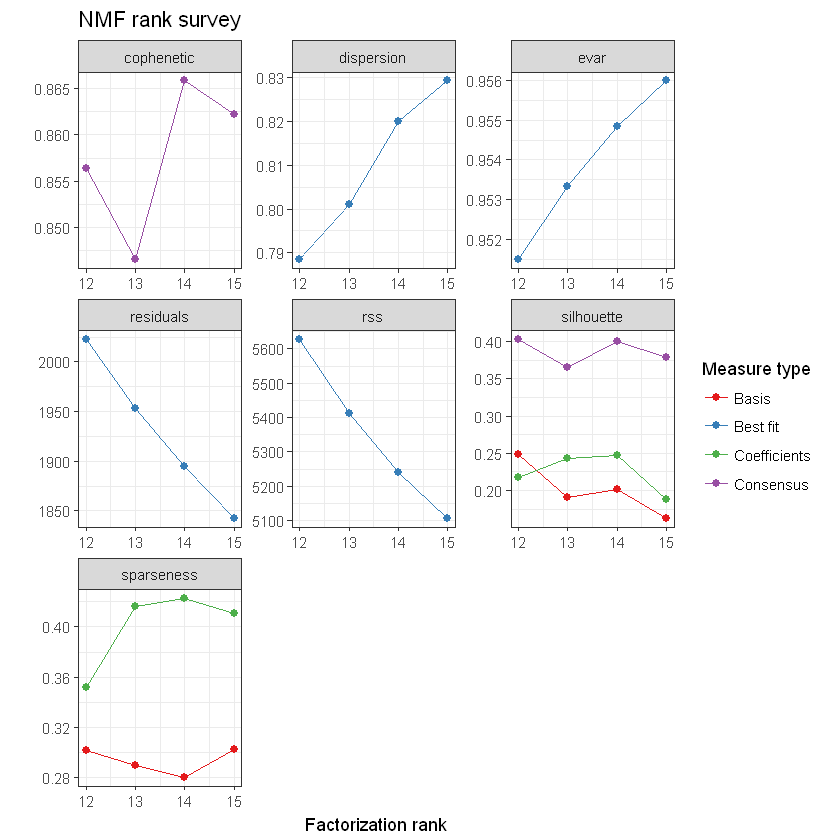

In [5]:
plot(res)

In [56]:
k<-14
sum_nmf <- summary(res)
k_list <- seq(12, k+1, 1)
cophenetic <- sum_nmf[,"cophenetic"]
peak <- rep(0, length(k_list))

for (i in 2:(length(cophenetic) - 1)) if (cophenetic[i-1] < cophenetic[i] & cophenetic[i] > cophenetic[i+1]) {
    peak[i] <- 1
}
    
peaks <- k_list[peak == 1]
k <- rev(peaks)[1]
    
print(paste("Suggested k value:", k))

[1] "Suggested k value: 14"


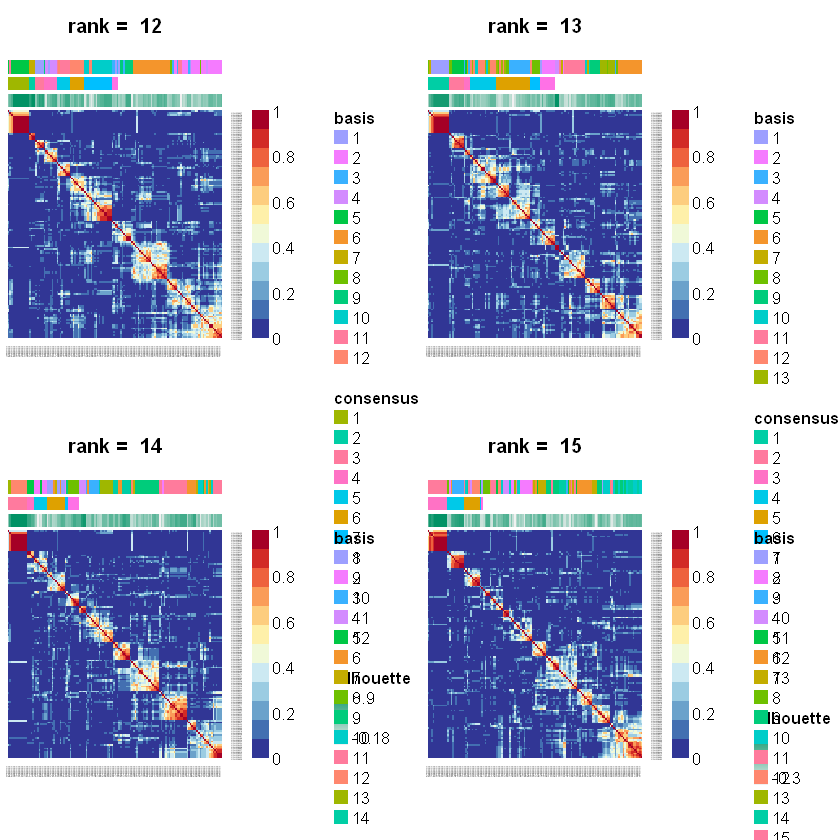

In [57]:
#The intent of the consensus map is to see how well the data segregates into k clusters.  

consensusmap(res)

In [67]:
#Mixture coefficients heatmap.  

#coefmap(res)

In [63]:
#Using result from previous nmf run to seed NMF to convergence with alternating least-squares solver.
#This takes a while to run.
res <- nmf(sub_nn_exprs, k, method=nmf_method)
res2 <- nmf(sub_nn_exprs, k, method="snmf/l", seed = res)

In [68]:
dim(res2)

[1] 500 132  14

In [65]:

#NMF factors matrix V into matrices W (weights) and H (basis).

#In this case, S = W (sample loadings) and G = H (gene loadings).


S <- coef(res2)
G <- basis(res2)

dim(S)
dim(G)

[1]  14 132

[1] 500  14

In [57]:
#Checkpoint

#G <- read.csv('geneLoadings.csv', header=TRUE)
#S <- read.csv('sampleLoadings.csv', header=TRUE)

In [69]:
#Normalize both G and S to make the column means of G = 1

for (i in 1:14){
    colMean <- mean(G[,i])
    G[,i] <- G[,i] / colMean
    S[i,] <- S[i,] * colMean
}

In [71]:
diff_G <- G

for (j in 1:14){
    for (i in 1:num_genes){
        diff_G[i, j] <- diff_G[i,j] - max(G[i, -j]) 
    }
}

#G2 is a matrix of differences between gene loading values (G) and the max loading value for that gene (outside of the present)
#column.


In [72]:
#sanity check

print(G[12,12])
print(max(G[12,]))
print(diff_G[12,12])

12 
 0 
[1] 3.56725
      12 
-3.56725 


In [73]:
#G3 is the difference absolute values

absVal_G <- abs(diff_G)

In [75]:
top_gene_cutoff = 50
num_samples = 132

topGenes <- mat.or.vec(top_gene_cutoff,k)

for(i in 1:14){
    topGenes[,i]<-rownames(head(absVal_G[order(absVal_G[,i], decreasing=TRUE),0],top_gene_cutoff))  
}

In [87]:

cluster_gene_loadings <- function(topGenes, rows, cols){
    distance_matrix <- dist(t(topGenes))
    hier_clust <- hclust(distance_matrix, method="complete")
    topGenes <- topGenes[,hier_clust$order]
    cols <- cols[hier_clust$order]
    distance_matrix <- dist(topGenes)
    hier_clust <- hclust(distance_matrix, method="complete")
    topGenes <- topGenes[hier_clust$order,]
    rows <- rows[hier_clust$order]
    return(list(topGenes = topGenes, rows = rows, cols = cols))
}

cluster_gene_loadings(topGenes, 50, 132)

300,10,357,10,278,133,482,482,300,462,482,379,31,149
317,229,431,256,307,5,5,452,261,431,452,431,452,317
386,386,386,386,386,386,386,386,386,386,386,386,386,386
379,462,278,133,237,44,302,379,482,482,405,131,462,405
347,452,229,431,5,229,256,431,5,229,431,347,307,431
259,278,133,461,58,10,278,302,72,10,278,462,302,10
452,346,97,149,372,97,372,372,215,372,149,461,195,97
44,409,117,44,149,41,409,405,44,259,141,278,259,377
461,372,461,195,72,405,195,175,195,461,461,175,405,259
237,379,379,41,14,376,10,300,302,405,379,470,62,237
6,149,346,176,229,357,357,346,176,357,346,357,346,357


In [50]:
x <- nat4[,0]
y <- colnames(nat4)

In [53]:
require(splines)

Loading required package: splines


In [54]:
n_rep <- 200
n_df <- 30
df <- 1:n_df

In [58]:
beta <- c(5, -0.1, 0.004, -3e-05)
n_train <- 104
n_test <- 10000
sigma_eps <- 0.5

In [60]:
fitted_models <- apply(t(nat4), 2, function(degf) lm(y ~ ns(x, df = degf)) )

Warning message in if (nIknots < 0L) {:
"the condition has length > 1 and only the first element will be used"Warning message in if (nIknots > 0L) {:
"the condition has length > 1 and only the first element will be used"Warning message in seq.int(0, 1, length.out = nIknots + 2L):
"first element used of 'length.out' argument"

ERROR: Error in quantile.default(x[!outside], knots): missing values and NaN's not allowed if 'na.rm' is FALSE


In [59]:
degf

ERROR: Error in eval(expr, envir, enclos): object 'degf' not found


In [61]:
xy <- res <- list()

In [67]:
library(klaR)

ERROR: Error in library(klaR): there is no package called 'klaR'


In [66]:
library(caret)

Loading required package: lattice
Loading required package: ggplot2


In [73]:
nat5 <- nat4[sample(nrow(nat4)),]

folds <- cut(seq(1,nrow(nat5)), breaks=5, labels=FALSE)

for(i in 1:10){
    testIndexes <- which(folds==i, arr.ind=TRUE)
    testData <- nat5[testIndexes, ]
    trainData <- nat5[-testIndexes,]
    
}

      GSM535948 GSM535949 GSM535950 GSM535951 GSM536032 GSM536033 GSM536034
20321 2.0986104 1.5340885 1.3189526 1.5789687 0.7301747 2.3596498 3.4831527
2903  0.9910281 2.4660418 1.9036421 0.8475206 2.8503496 1.9036421 2.3315361
11097 0.5607151 0.5338851 0.4253877 0.5747030 0.6162856 2.5633882 0.6011406
21343 1.3430525 1.1710764 1.3840124 1.2915671 1.3267560 1.1755292 1.1638641
27789 2.5418199 2.4931249 2.7187108 3.5580066 1.7676287 0.5298766 0.5823008
37583 1.4038352 0.8663307 0.9099954 1.2963044 0.8974274 1.3430525 1.1616507
      GSM536035 GSM536036 GSM536037 GSM536038 GSM536039 GSM536040 GSM536041
20321 0.8918819 4.1817685 3.7828199 2.6134113 2.7153192 3.2198090 3.0250954
2903  1.9723673 1.9664102 2.3822368 1.3249527 1.5769736 1.5472138 1.4433483
11097 2.8219708 2.0233405 2.8185371 2.2032017 2.3604550 3.0382611 2.6713591
21343 1.2892025 1.0801075 1.3237514 0.9737434 1.1710764 1.2803590 1.1934496
27789 0.6410082 0.4162797 0.5620045 1.0975928 0.7301747 0.6691059 0.3838439
37583 1.2645

In [74]:
train_control <- trainControl(method="cv", number=5)

In [75]:
grid <- expand.grid(.fL=c(0), .usekernel=c(FALSE))

In [ ]:
model <- train(Species~., data=res2, trControl=train_control, method="nb", tuneGrid=grid)
# summarize results
print(model)